# Importing packages

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib
# to split the datasets
from sklearn.preprocessing import LabelEncoder

#Scaler and impute
from sklearn.impute import KNNImputer
from sklearn.preprocessing import  StandardScaler, MinMaxScaler, OneHotEncoder

#outlier models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

#K-means 
#silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples

# Hierarchical Clustering 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.mixture import GaussianMixture

#KNN for missing clusters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

#Umap
import umap.plot as umap_plot
import umap.umap_ as umap

#Kprototype
import plotnine
from kmodes.kprototypes import KPrototypes

from sklearn.base import clone
from sklearn.manifold import TSNE

# Decision TreeClassifer 
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier, export_graphviz
import pydotplus
import graphviz

# Reading the database

In [2]:
df = pd.read_sas('../data/a2z_insurance.sas7bdat')
df.drop('CustID', axis=1, inplace=True)

# Describing the data

In [3]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,10266.0,NaN,NaN,NaN,1991.062634,511.267913,1974.0,1980.0,1986.0,1992.0,53784.0
BirthYear,10279.0,NaN,NaN,NaN,1968.007783,19.709476,1028.0,1953.0,1968.0,1983.0,2001.0
EducDeg,10279,4,b'3 - BSc/MSc',4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10260.0,NaN,NaN,NaN,2506.667057,1157.449634,333.0,1706.0,2501.5,3290.25,55215.0
GeoLivArea,10295.0,NaN,NaN,NaN,2.709859,1.266291,1.0,1.0,3.0,4.0,4.0
Children,10275.0,NaN,NaN,NaN,0.706764,0.455268,0.0,0.0,1.0,1.0,1.0
CustMonVal,10296.0,NaN,NaN,NaN,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
ClaimsRate,10296.0,NaN,NaN,NaN,0.742772,2.916964,0.0,0.39,0.72,0.98,256.2
PremMotor,10262.0,NaN,NaN,NaN,300.470252,211.914997,-4.11,190.59,298.61,408.3,11604.42
PremHousehold,10296.0,NaN,NaN,NaN,210.431192,352.595984,-75.0,49.45,132.8,290.05,25048.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.0+ MB


In [5]:
pd.concat([df.isna().sum(),df.isna().sum()/len(df)*100],axis=1).rename(columns={0:'Frequency',1:'Percentage'})

,Frequency,Percentage
FirstPolYear,30,0.291375
BirthYear,17,0.165113
EducDeg,17,0.165113
MonthSal,36,0.349650
GeoLivArea,1,0.009713
Children,21,0.203963
CustMonVal,0,0.000000
ClaimsRate,0,0.000000
PremMotor,34,0.330225
PremHousehold,0,0.000000


# Coherence Check 

#### FirstPolYear against BirthYear

In [6]:
df[df.FirstPolYear<df.BirthYear]["Children"].value_counts()

1.0    1657
0.0     337
Name: Children, dtype: int64

In [7]:
df[df.FirstPolYear>df.BirthYear]["Children"].value_counts()

1.0    5435
0.0    2647
Name: Children, dtype: int64

In [8]:
 df[(df.FirstPolYear<df.BirthYear) & (df.Children==1) & (df.BirthYear>=1998)].shape[0]

159

In [9]:
# There's no customers with less than 16 yeards old and with a child simultaniously 
df[(df.FirstPolYear>df.BirthYear) & (df.Children==1) & (df.BirthYear>=2000)].shape[0]

0

#### Check if people with 16 years or less has a Bachelor or PHD

In [10]:
df.EducDeg=df.EducDeg.str.decode("utf-8")

df[(df.BirthYear>=2000) & ((df.EducDeg.str.contains("PhD")) | (df.EducDeg.str.contains("BSc/MSc")))].shape[0]

0

#### Check for consistent Birthday and FirstPolicy Years 

In [11]:
print(df[(df.BirthYear<1890) | (df.BirthYear>2016)].shape[0])
print(df[(df.FirstPolYear<1890) | (df.FirstPolYear>2016)].shape[0])


1
1


In [12]:
df.replace({'BirthYear':1028},np.nan,inplace = True)
df.replace({'FirstPolYear':53784},np.nan,inplace = True)

#### Swap the the values of FirstPolYear and Birthyear, when FirstPolYear<df.BirthYear 

In [13]:
index=df[(df.FirstPolYear<df.BirthYear)]["BirthYear"].index
df.loc[index,"FirstPolYear"],df.loc[index,"BirthYear"]=df[(df.FirstPolYear<df.BirthYear)]["BirthYear"],df[(df.FirstPolYear<df.BirthYear)]["FirstPolYear"]

# Fill NaN for outlier detection

In [14]:
df.isna().sum()

FirstPolYear      31
BirthYear         18
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [15]:
metric_features = df.select_dtypes(include = np.number).columns.drop(pd.Index(['GeoLivArea', 'Children'])).to_list()
categorical_features = df.select_dtypes(exclude = np.number).columns.append(pd.Index(['GeoLivArea', 'Children'])).to_list()

df_fillna = df.copy()
modes_cat = df[categorical_features].mode().loc[0]
median_num = df[metric_features].median()

df_fillna.fillna(modes_cat,inplace=True)
df_fillna.fillna(median_num,inplace=True)

df_fillna.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

# Graphs

### Categorical Datas

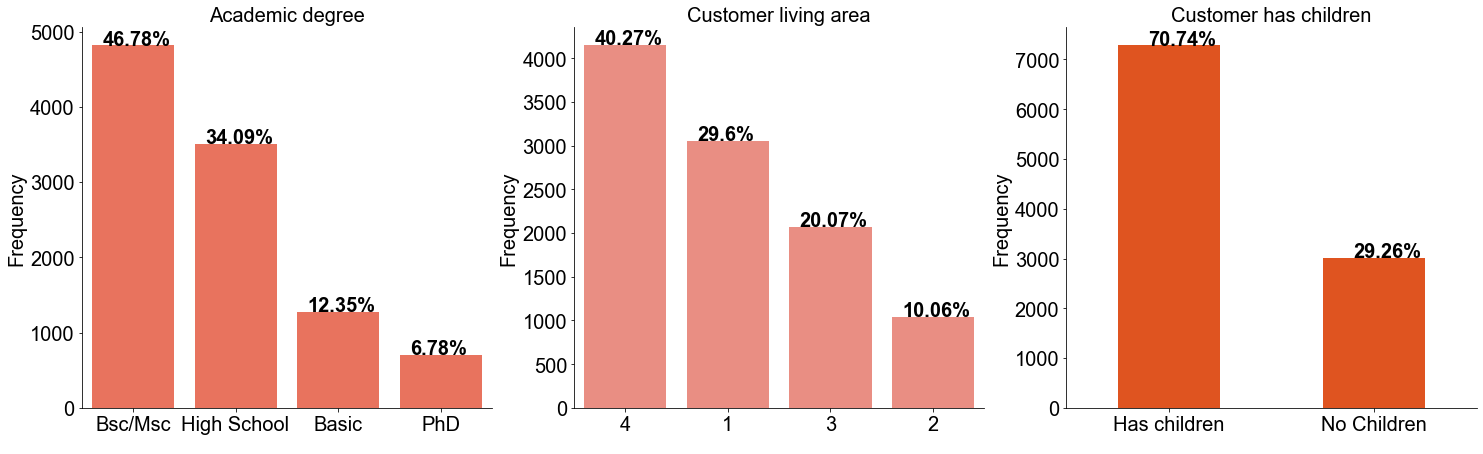

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

sns.despine()
sns.countplot(x=df_fillna['EducDeg'], 
              color = 'tomato', 
              ax = ax[0], 
              order = df_fillna['EducDeg'].value_counts().sort_values(ascending = False).index)


ax[0].tick_params(axis='both',labelsize=20)
ax[0].set_xticklabels(labels=['Bsc/Msc','High School','Basic','PhD'])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('Frequency', fontsize=20)
ax[0].set_title('Academic degree', fontsize=20)
percet = round(df_fillna['EducDeg'].value_counts(normalize = True)*100,2).values
freq =  df_fillna['EducDeg'].value_counts().values
for k,value in enumerate(percet):
    ax[0].text(k-0.3 ,  freq[k]+10   , str((value))+'%', color='black', fontweight='bold',fontsize=20)

    
sns.countplot(x=df_fillna['GeoLivArea'], 
              color = 'salmon', 
              ax = ax[1], 
              order = df_fillna['GeoLivArea'].value_counts().sort_values(ascending = False).index)
ax[1].tick_params(axis='both',labelsize=20)
ax[1].set_xticklabels(labels=['4','1','3','2'])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('Frequency', fontsize=20)
ax[1].set_title('Customer living area', fontsize=20)
percet = round(df_fillna['GeoLivArea'].value_counts(normalize = True)*100,2).values
freq =  df_fillna['GeoLivArea'].value_counts().values
for k,value in enumerate(percet):
    ax[1].text(k-0.3 ,  freq[k]+10   , str((value))+'%', color='black', fontweight='bold',fontsize=20)


sns.countplot(x=df_fillna['Children'], 
              color = 'orangered', 
              ax = ax[2], 
              order = df_fillna['Children'].value_counts().sort_values(ascending = False).index)
ax[2].tick_params(axis='both',labelsize=20)
ax[2].set_xticklabels(labels=['Has children','No Children'])
ax[2].set_xlabel(' ')
ax[2].set_ylabel('Frequency', fontsize=20)
ax[2].set_title('Customer has children', fontsize=20)
percet = round(df_fillna['Children'].value_counts(normalize = True)*100,2).values
freq =  df_fillna['Children'].value_counts().values
for k,value in enumerate(percet):
    ax[2].text(k-0.1 ,  freq[k]+10   , str((value))+'%', color='black', fontweight='bold',fontsize=20)

    
for bar,newwidth in zip(ax[2].patches,[0.5,0.5]):
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.

    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)


sns.set_style("whitegrid",{  "grid.linestyle": "dashed"})

plt.show()

### Continous variables

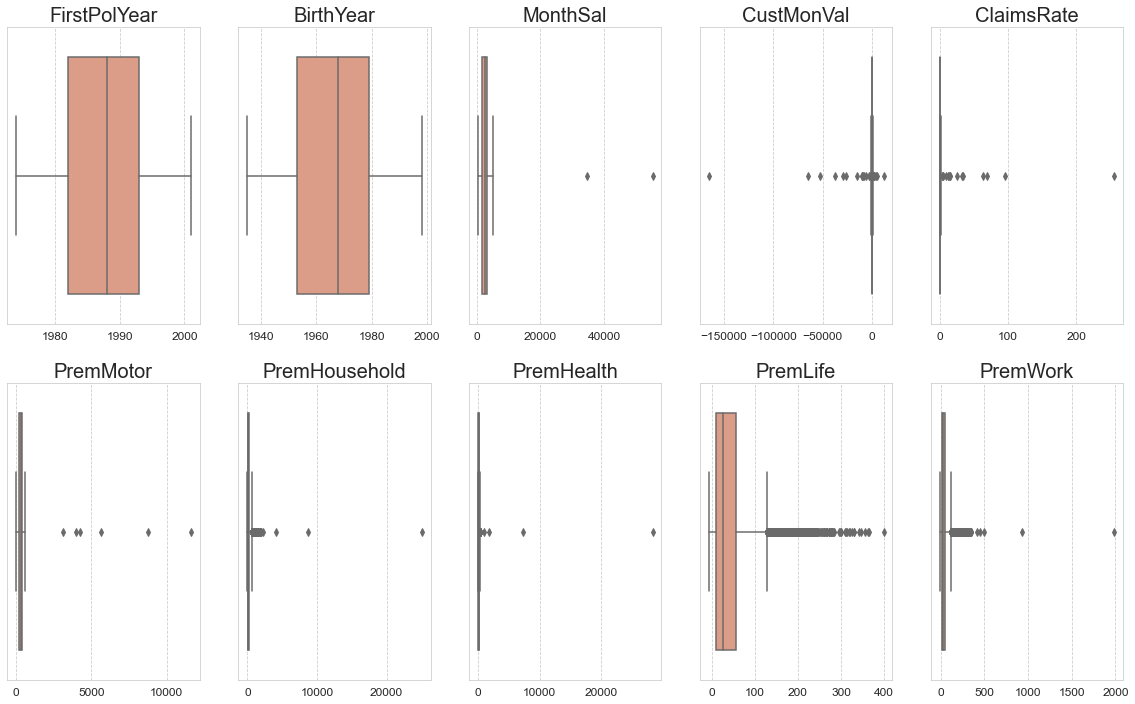

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(20, 12))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_fillna[feat],ax=ax,color='darksalmon')
    ax.set_title(feat, fontsize=20)
    ax.tick_params(axis='both',labelsize=12)
    ax.set_xlabel('')


# Outlier detection

### Eye method

In [18]:
df_eye = df_fillna.copy()

Percentage of data kept after removing outliers: 0.9844 
Total values removed:  161


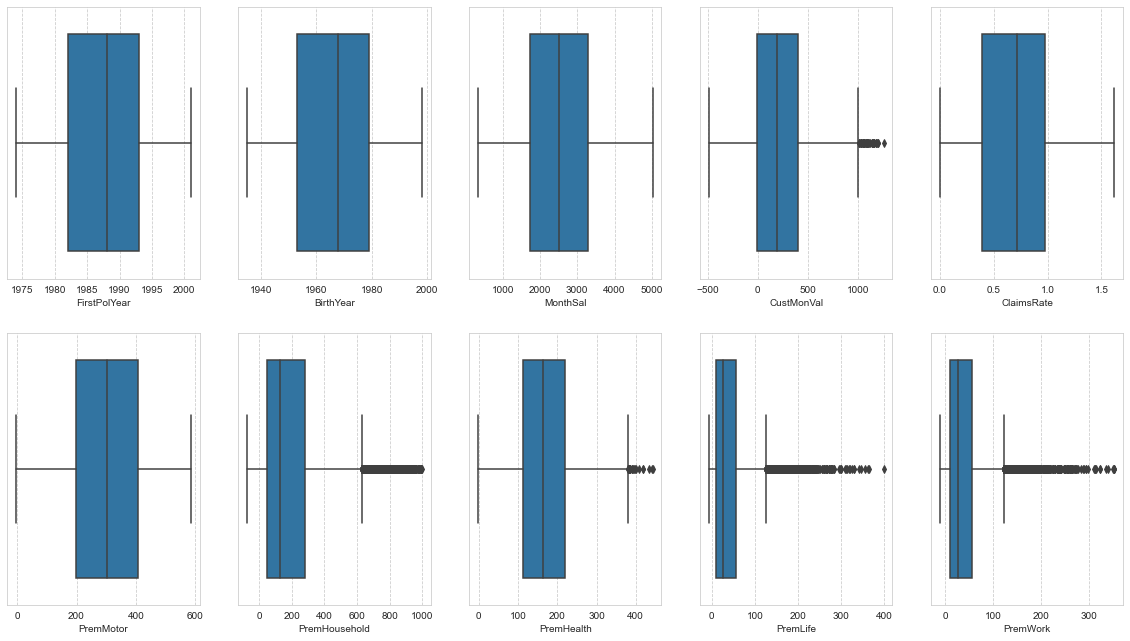

In [19]:
filters= (
    (df_eye['PremMotor']<2000) 
    & 
    (df_eye['ClaimsRate']<4)
    &
    (df_eye['PremHealth']<1000)
    &
    (df_eye['PremHousehold']<1000)
    &
    (df_eye['PremWork']<400)
    &
    (df_eye['CustMonVal']>-2000)
     &
    (df_eye['MonthSal']<10000)
   )

df_eye = df_eye[filters]

print('Percentage of data kept after removing outliers:', np.round(df_eye.shape[0] / df.shape[0], 4), "\n" + "Total values removed: ",
     df.shape[0]-df_eye.shape[0])
fig, axes = plt.subplots(2, 5, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_eye[feat],ax=ax)

### IQR method

In [20]:
df_iqr = df_fillna.copy()

Percentage of data kept after removing outliers: 0.831 
Total values removed:  1740


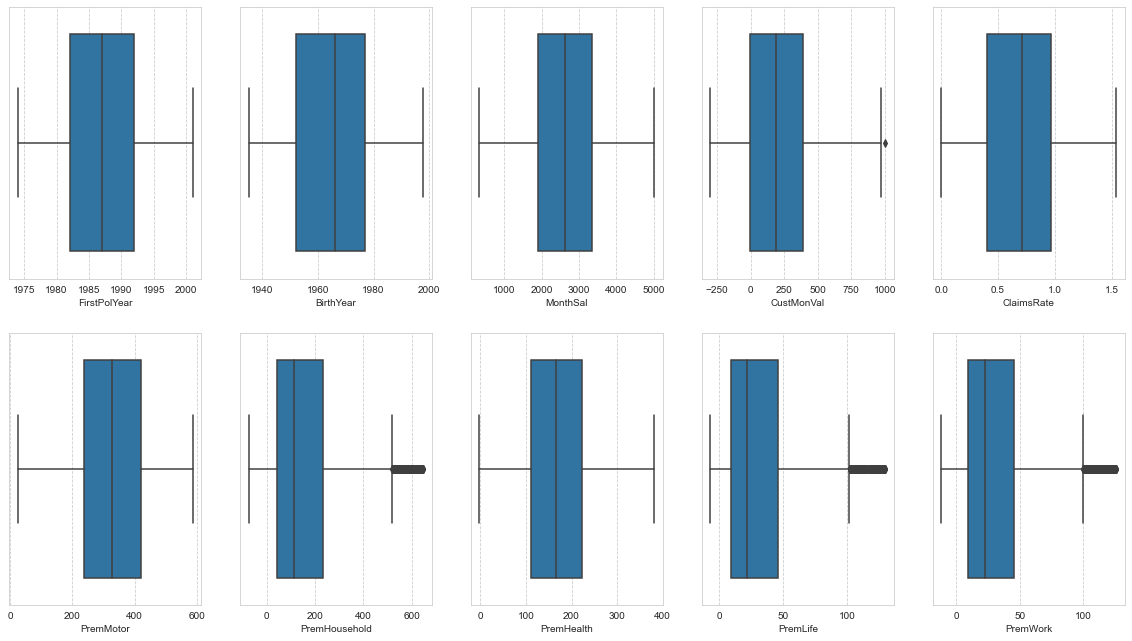

In [21]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr


filters = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters.append(df[metric].between(llim, ulim, inclusive=True))
    

df_iqr = df_iqr[np.all(filters, 0)]
print('Percentage of data kept after removing outliers:', np.round(df_iqr.shape[0] / df.shape[0], 4), "\n" + "Total values removed: ",
     df.shape[0]-df_iqr.shape[0])

fig, axes = plt.subplots(2, 5, figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_iqr[feat],ax=ax)


### Eye + boxplot

Percentage of data removed 1.3209 
Total values removed:  136


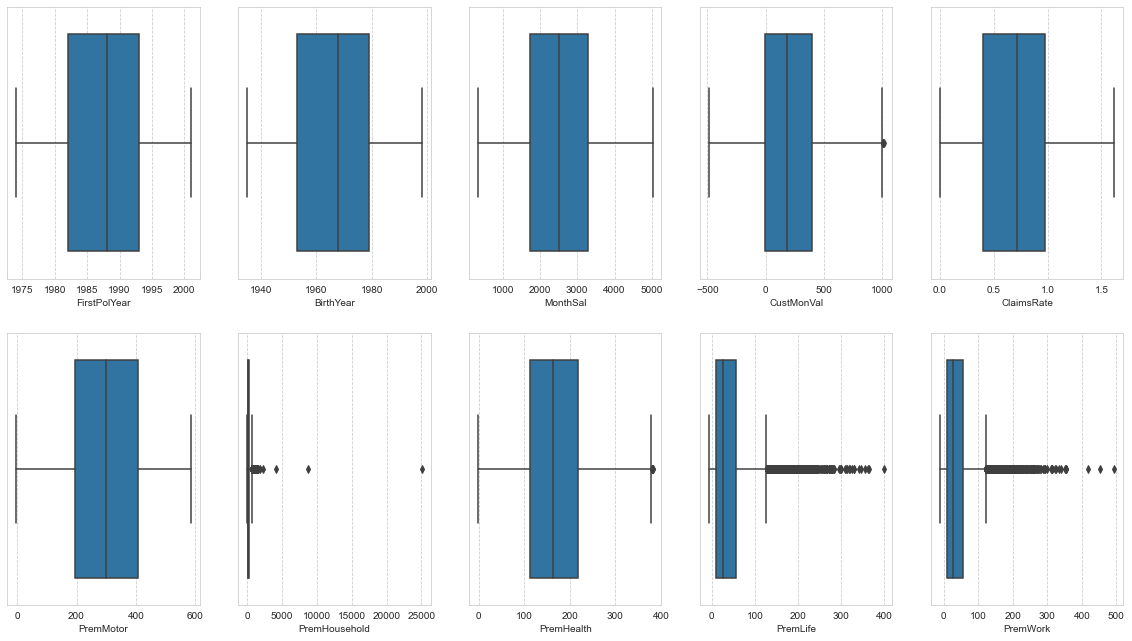

In [22]:
df_no_out = df_fillna.copy()

filters= (
    (df_no_out['PremMotor']<2000)
   &
    (df_no_out['ClaimsRate']<4))

df_outliers = df_no_out[~filters]
df_no_out = df_no_out[filters]


##############################################################
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr
features = ['MonthSal','CustMonVal','PremHealth','PremMotor']

filters_iqr = []
for metric in features:
    llim = lower_lim[metric]
    #print(llim)
    ulim = upper_lim[metric]
    #print(ulim)
    filters_iqr.append(df_no_out[metric].between(llim, ulim, inclusive=True))
    
df_outliers = pd.concat([df_outliers,df_no_out[~np.all(filters_iqr, 0)]])
df_no_out = df_no_out[np.all(filters_iqr, 0)]

###############################################################
df_no_out.reset_index(drop=True,inplace=True)

fig, axes = plt.subplots(2, 5, figsize=(20, 11))

print('Percentage of data removed', np.round((1-df_no_out.shape[0] / df.shape[0])*100, 4), "\n" + "Total values removed: ",
     df.shape[0]-df_no_out.shape[0])

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df_no_out[feat],ax=ax)

### LOF method

Text(0.5, 1.0, 'Maximun of LOF scores for observation')

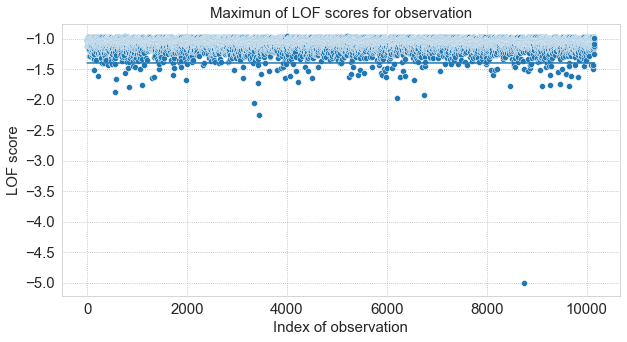

In [23]:
scaler = MinMaxScaler()
df_out_scal = pd.DataFrame(scaler.fit_transform(df_no_out[metric_features]), 
                           index=df_no_out[metric_features].index,
                           columns = df_no_out[metric_features].columns)

LOF = LocalOutlierFactor(n_neighbors = 20 , metric = 'minkowski', p =1 )
LOF.fit_predict(df_out_scal)
matrix_values = LOF.negative_outlier_factor_

n_neighbors = np.arange(21,71)
for n in n_neighbors:
    LOF = LocalOutlierFactor(n_neighbors = n , metric = 'minkowski', p =1 )
    LOF.fit_predict(df_out_scal)
    matrix_values = np.column_stack((matrix_values,LOF.negative_outlier_factor_))
    
Max_score_outlier = np.amin(matrix_values,axis=1)

#ax.set(ylim=(-0.2*1e8,-2*1e10))

sns.set_style("whitegrid",{"grid.color": ".7", "grid.linestyle": ":"})
fig,ax = plt.subplots(figsize=(10,5))
ax=sns.scatterplot(x=np.arange(0,len(Max_score_outlier)),y=Max_score_outlier)
plt.plot(np.arange(0,len(Max_score_outlier)),np.full((len(Max_score_outlier),1),-1.4))
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('LOF score',size=15)
plt.xlabel('Index of observation',size=15)
plt.title('Maximun of LOF scores for observation',size=15)

In [24]:
df_no_out_2 = df_no_out.copy()
df_outliers = pd.concat([df_outliers,df_no_out.iloc[np.argwhere(Max_score_outlier<-1.4).flatten()]])
df_no_out_2.drop(np.argwhere(Max_score_outlier<-1.4).flatten(), inplace = True)
df_no_out_2.reset_index(drop=True,inplace=True)

Percentage of data removed 2.4864 
Total values removed:  256


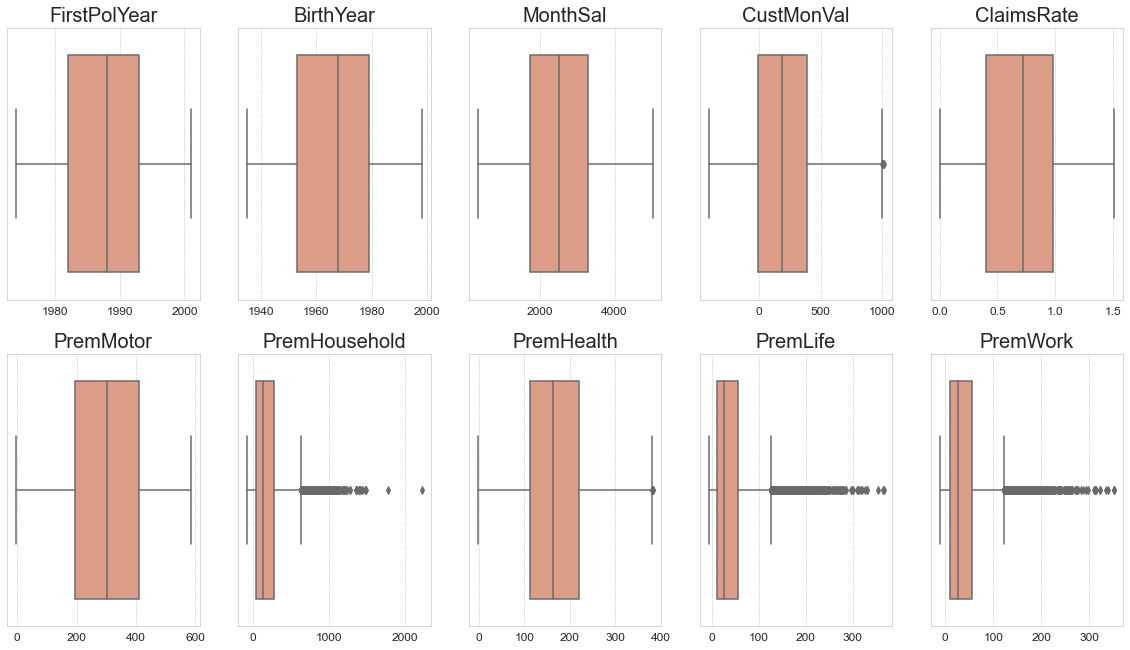

In [25]:
print('Percentage of data removed', np.round((1-df_no_out_2.shape[0] / df.shape[0])*100, 4), "\n" + "Total values removed: ",
     df.shape[0]-df_no_out_2.shape[0])

fig, axes = plt.subplots(2, 5, figsize=(20, 11))
for ax, feat in zip(axes.flatten(), metric_features):
     sns.boxplot(x=df_no_out_2[feat],ax=ax,color='darksalmon')
     ax.set_title(feat, fontsize=20)
     ax.tick_params(axis='both',labelsize=12)
     ax.set_xlabel('')

# Fill Missing Values using KNN imputation

In [26]:
# create a new dataframe with the outliers removed and with the original missing values only from the metric_features 
df_miss_in=df_no_out_2.copy()
df_miss_in[metric_features]=df_no_out_2[metric_features][~df[metric_features].isnull()]

In [27]:
# Fill missing values with KNNImputter method 
scaler = MinMaxScaler()
df_miss_in_scal = pd.DataFrame(scaler.fit_transform(df_miss_in[metric_features]), index=df_miss_in.index, columns = metric_features)

imputer = KNNImputer(n_neighbors=5,weights='distance')
train_t= imputer.fit_transform(df_miss_in_scal)

df_final=pd.DataFrame(scaler.inverse_transform(train_t), columns = metric_features, index=df_miss_in.index)
df_final = pd.concat([df_final,df_miss_in[categorical_features]],axis=1)
df_final['GeoLivArea'] = df_final['GeoLivArea'].astype(object)
df_final['Children'] = df_final['Children'].astype(object)

In [28]:
# Non missing values present
df_final.isna().sum()

FirstPolYear     0
BirthYear        0
MonthSal         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
EducDeg          0
GeoLivArea       0
Children         0
dtype: int64

# Feature engineering

In [29]:
# After missing values imputation, there's 5 observations with FirstPolYear<BirthYear 
# Swap the the values of FirstPolYear and Birthyear, when FirstPolYear<df.BirthYear, as previously done on the coherence check
# chapter

index=df_final[(df_final.FirstPolYear<df_final.BirthYear)]["BirthYear"].index
df_final.loc[index,"FirstPolYear"],df_final.loc[index,"BirthYear"]=df_final[(df_final.FirstPolYear<df_final.BirthYear)]["BirthYear"],df_final[(df_final.FirstPolYear<df_final.BirthYear)]["FirstPolYear"]

In [30]:
# Create new variables 

def custom_sum(row):
    return row.sum()

df_final['PremTotal'] = df_final[['PremMotor','PremWork','PremLife','PremHealth','PremHousehold']].apply(custom_sum,axis=1)

df_final['income_commit'] = df_final['PremTotal']/(df_final['MonthSal']*12)

df_final['ActualAge'] = 2016 - df_final['BirthYear']

df_final['TimeCustm'] = 2016 - df_final['FirstPolYear']

df_final['AgeFirstPol'] = df_final['FirstPolYear'] - df_final['BirthYear']

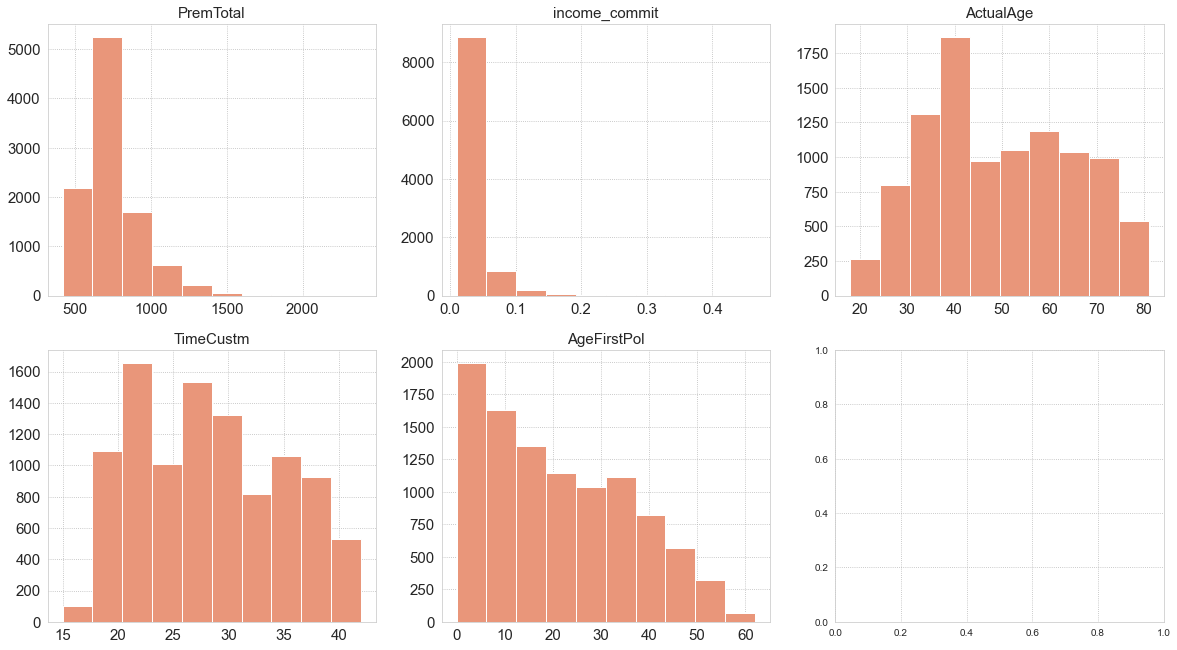

In [31]:
var_new=['PremTotal','income_commit','ActualAge','TimeCustm','AgeFirstPol']
fig, axes = plt.subplots(2, 3, figsize=(20, 11))
for ax, feat in zip(axes.flatten(), var_new):
    
    ax.hist(x=df_final[feat], color='darksalmon')
    ax.set_title(feat, fontsize=15)
    ax.tick_params(axis='both',labelsize=15)

# Feature selection

### Study the categorical variable GeoLivArea

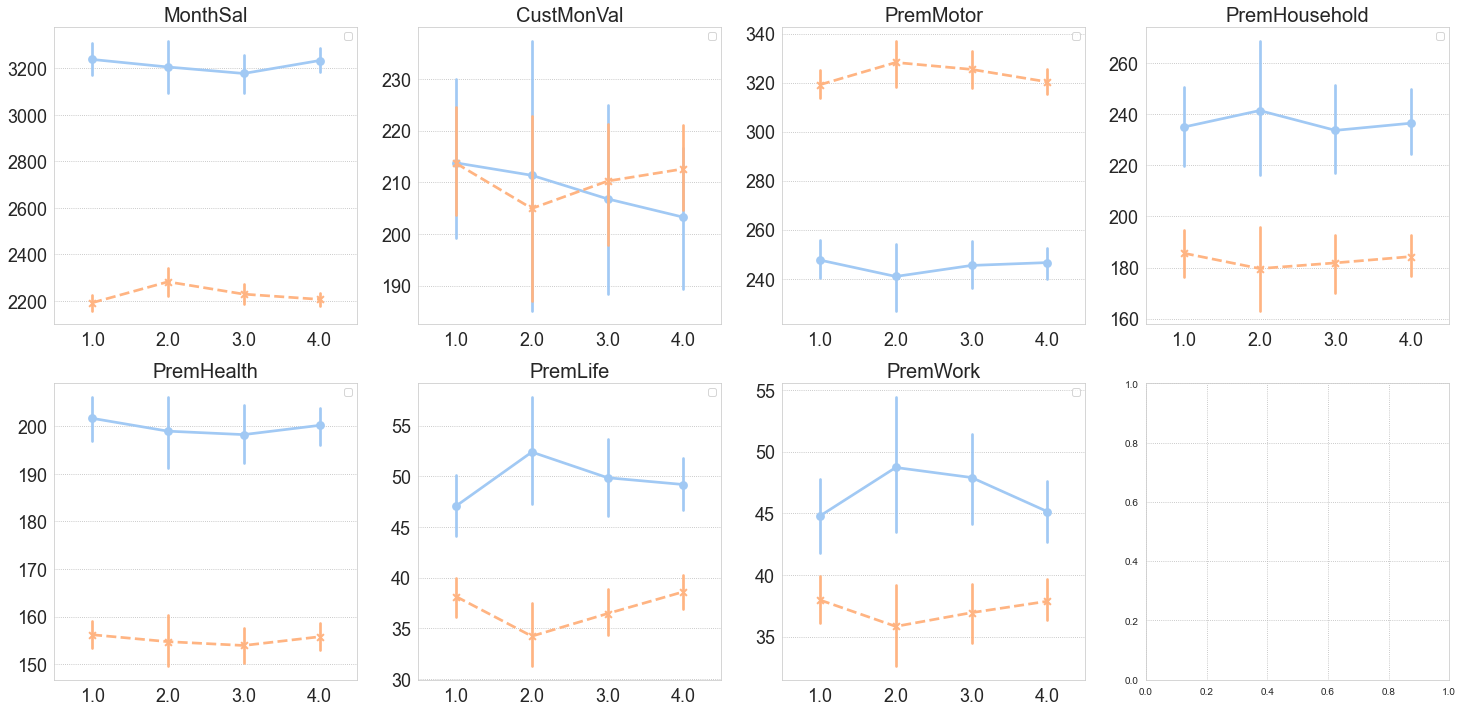

In [32]:
metric_plot = ['MonthSal', 'CustMonVal', 'PremMotor', 'PremHousehold','PremHealth', 'PremLife', 'PremWork']

fig, axes = plt.subplots(2,4, figsize=(25,12))

for ax, feat in zip(axes.flatten(), metric_plot):
    
    sns.pointplot(y=df_final[feat],x=df_final['GeoLivArea'],ax=ax,color='darksalmon',hue=df_final['Children'],
                 markers=["o", "x"],
                  linestyles=["-", "--"],
                 palette = 'pastel')
    
    ax.set_title(feat, fontsize=20)
    ax.tick_params(axis='both',labelsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('')

### Study the categorical variable EducDeg

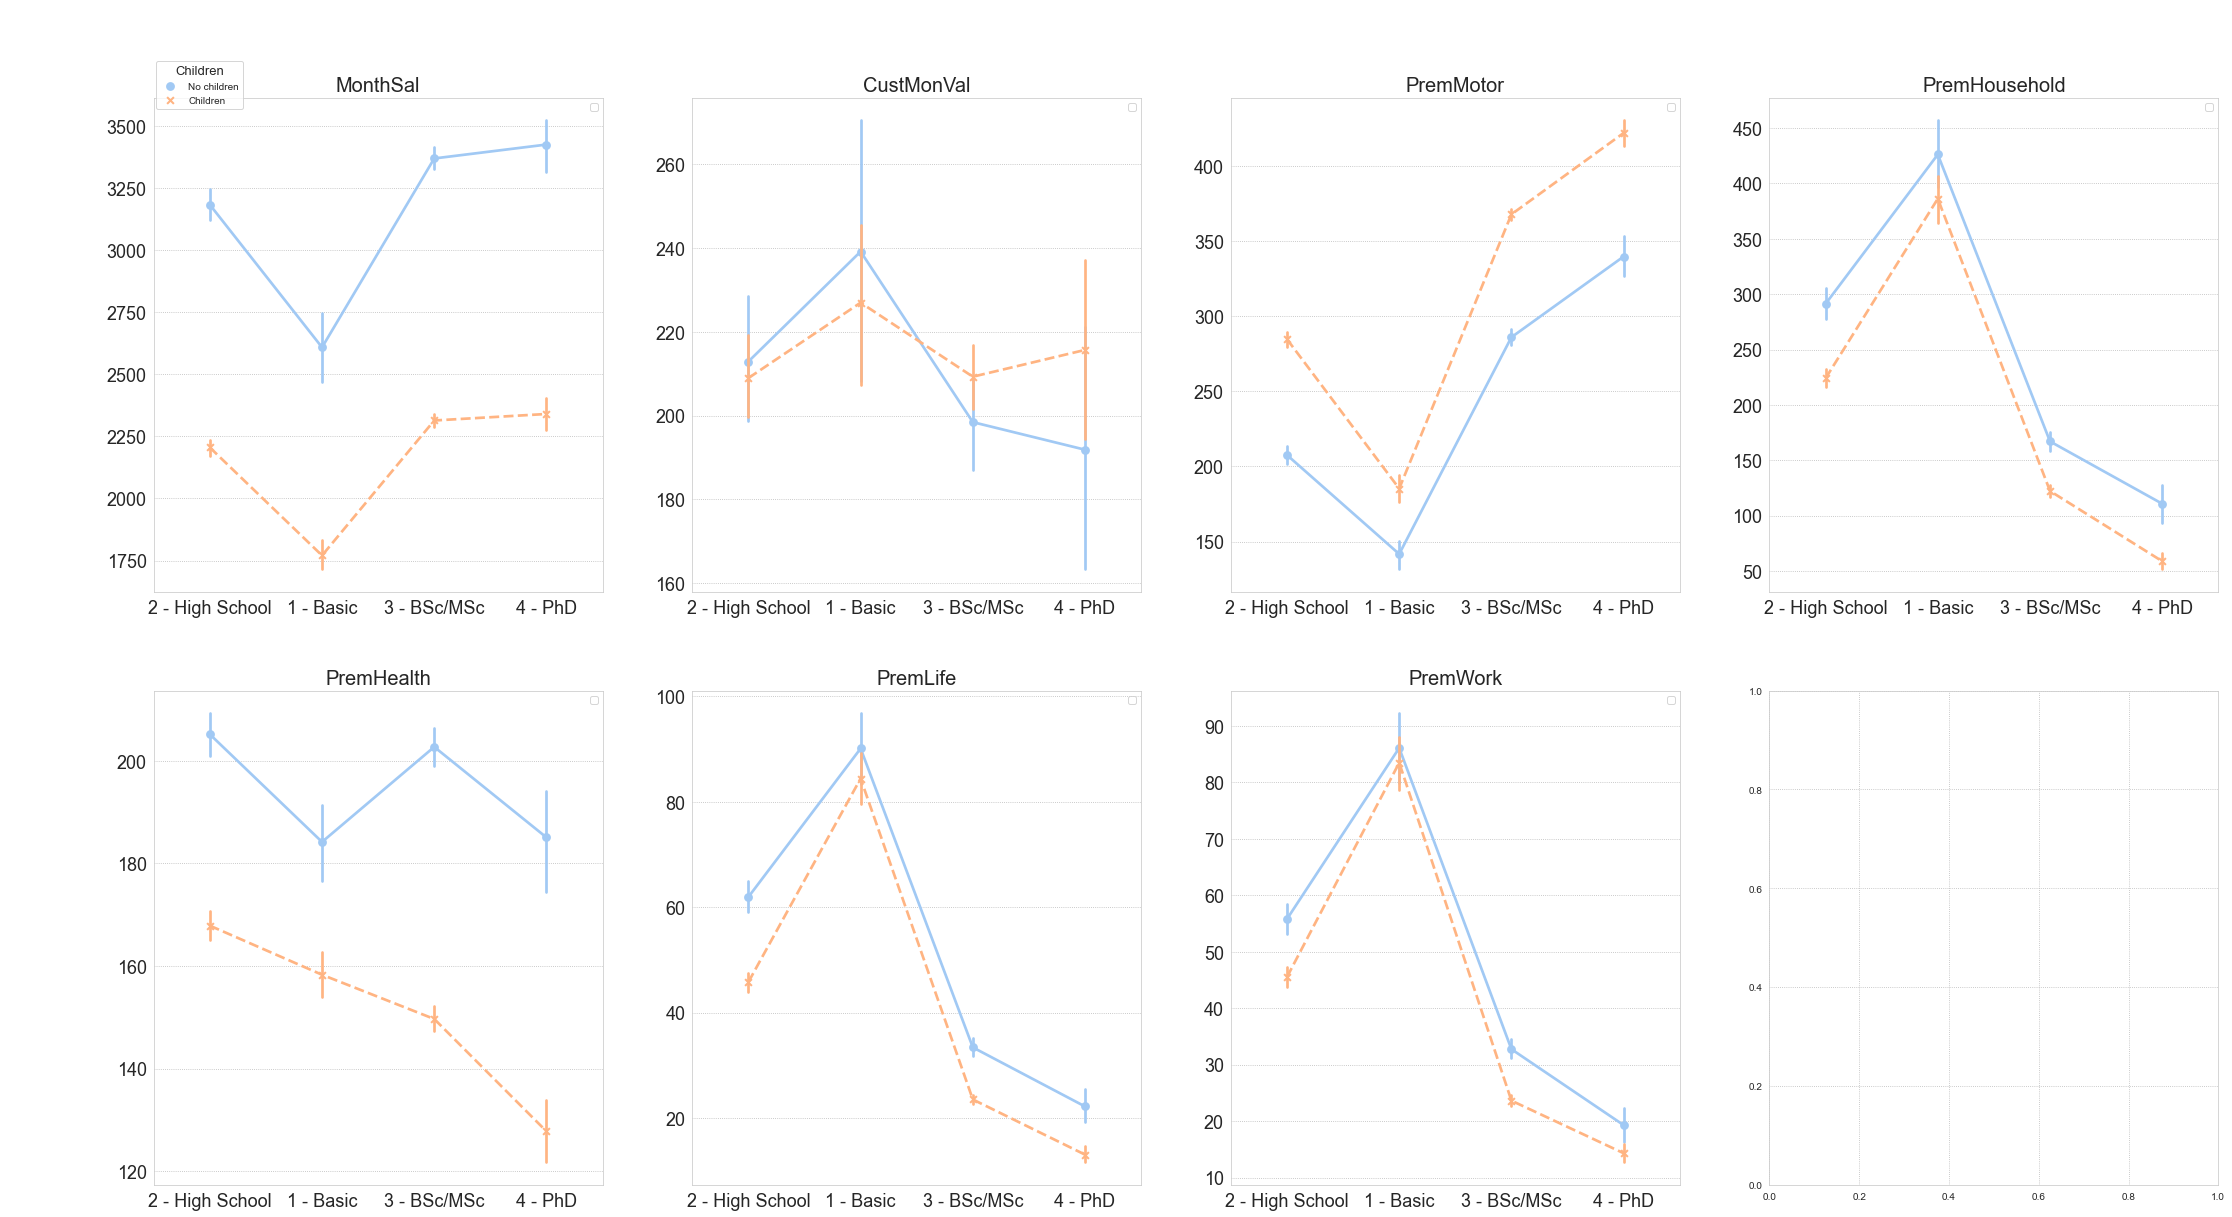

In [33]:
fig, axes = plt.subplots(2,4, figsize=(37,20))

for ax, feat in zip(axes.flatten(), metric_plot):
    
    sns.pointplot(y=df_final[feat],x=df_final['EducDeg'],ax=ax,color='darksalmon',hue=df_final['Children'],
                 markers=["o", "x"],
                  linestyles=["-", "--"],
                 palette = 'pastel')
    
    ax.set_title(feat, fontsize=20)
    ax.tick_params(axis='both',labelsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('')
        
handles, _ = axes[0,0].get_legend_handles_labels()
fig.legend(handles, ["No children","Children"], loc=(0.07,0.91), title="Children", title_fontsize=13)

### Study correlation of all numerical variables

In [34]:
# Updating metric_features to check the Spearmon Correlation 
metric_features.append("PremTotal")
metric_features.append('income_commit')
metric_features.append('AgeFirstPol')
metric_features.append('ActualAge')
metric_features.append('TimeCustm')

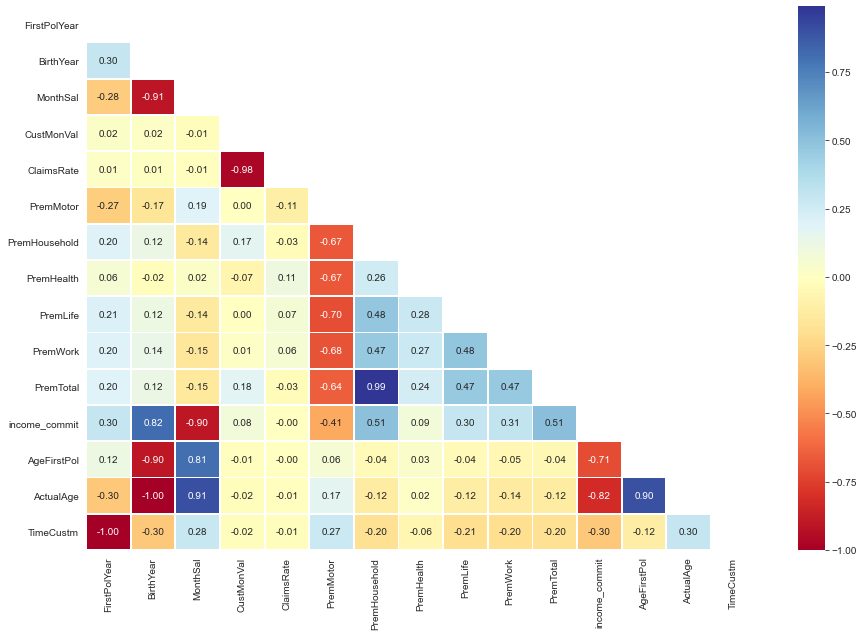

In [35]:
cor_spearman = df_final[metric_features].corr(method='spearman')
plt.figure(figsize=(15,10))
mask = np.zeros_like(cor_spearman)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = cor_spearman,mask = mask, annot = True, cmap = 'RdYlBu', fmt='.2f', linewidths=.8)
plt.show()

In [36]:
# Variables Highly correlated 
    ## ClaimsRate & CustMonVal - remove CustMonVal
    ## PremTotal & PremHousehold - removePremTotal
    ## FirstPolyYear & TimeCustm - remove FirstPolyYear
    ## Birthyear & Actual Age - remove Birthyear 
    ## AgefirstPol vs Actual Age - remove AgeFirstPol  
    
# Variables highly correlated with several variables 
    ## BirthYear - remove 


# K-Means and Hierarchical Clusterting
    

### Data Standardization 

In [37]:
df_KH=df_final.copy()

In [38]:
metric_features

['FirstPolYear',
 'BirthYear',
 'MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'PremTotal',
 'income_commit',
 'AgeFirstPol',
 'ActualAge',
 'TimeCustm']

In [39]:
product_value_features=['ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork','income_commit']

scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_KH[product_value_features])
df_KH[product_value_features] = scaled_feat
df_KH[product_value_features].head(3)

,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,income_commit
0,-0.937772,0.556767,-0.544436,-0.300739,0.132681,-0.512456,-0.247806
1,1.391112,-1.627855,0.990178,-0.705396,3.343322,1.470114,2.826994
2,-1.288700,-0.685669,0.116576,-0.597787,0.989171,1.312157,-0.190060


In [40]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers
kmeans = KMeans(
    init='k-means++',
    n_init=20,
    random_state=42
)

hierarchical = AgglomerativeClustering(
    affinity='euclidean'
)

In [41]:
# Obtaining the R² scores for each cluster solution on product_value variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_KH[product_value_features], kmeans)

for linkage in ['complete', 'average', 'single', 'ward']:
    r2_scores[linkage] = get_r2_scores(
        df_KH[product_value_features], hierarchical.set_params(linkage=linkage)
    )

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.298742,0.010992,0.004690,0.004690,0.273478
3,0.444051,0.104424,0.048679,0.011399,0.383559
4,0.519646,0.242179,0.126077,0.012323,0.455943
5,0.567497,0.252524,0.129109,0.012417,0.514194
6,0.600669,0.281589,0.166032,0.013844,0.549132
7,0.628211,0.291187,0.174692,0.014813,0.574850
8,0.650513,0.294835,0.191001,0.017868,0.597535
9,0.671489,0.297468,0.191585,0.018544,0.617970


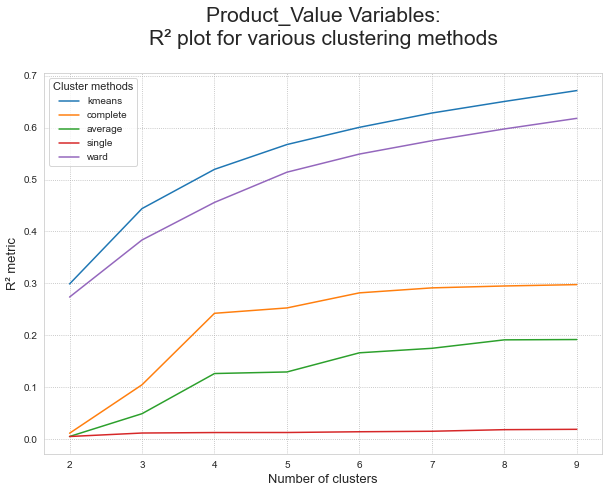

In [42]:
# Visualizing the R² scores for each cluster solution on product_value variables
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product_Value Variables:\nR² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

## K_Means and Hierarchical_Clustering on Top

**Iniciate K_means with 50 clusters**

In [43]:
kmclust50 = KMeans(n_clusters=50, init='k-means++', n_init=15, random_state=1)
kmclust50.fit(df_KH[product_value_features])

# An array with the number of clusters and its centroids position
clusters50=kmclust50.cluster_centers_
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df_KH[product_value_features].index.values
cluster_map['cluster'] = kmclust50.labels_

#save the centroids inverting the normalization
clusters50 = pd.DataFrame(scaler.inverse_transform(clusters50),columns = df_KH[product_value_features].columns)
clusters50.index.name="K_MeansCentroids"

**Check the Hierarchical Clustering solution on top of the K_means with 50 Clusters**

In [44]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(clusters50)  

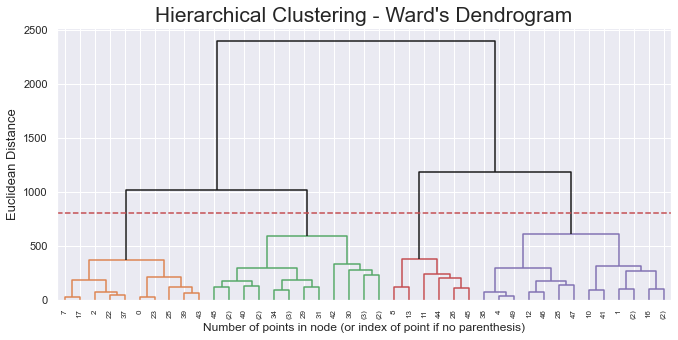

In [45]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

# The Dendrogram parameters need to be tuned
y_threshold = 800
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

**Based on Ward's Dendrogam - 4 clusters chosen**

In [46]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc_labels= hclust.fit_predict(clusters50) 

In [47]:
df_KH_final = pd.concat((clusters50, pd.Series(hc_labels, name='centroids')), axis=1)
df_KH_final.groupby('centroids').mean()

,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,income_commit
centroids,,,,,,,
0,0.636780,146.776416,515.339821,181.279125,84.063010,75.690244,0.066402
1,0.774721,173.903004,194.809844,207.796758,83.256789,84.349984,0.037121
2,0.850377,79.837823,911.636137,140.156672,89.550704,97.973802,0.156897
3,0.664970,405.423328,95.087449,126.479173,19.166192,19.035816,0.022863


**Assign to the initial dataframe the respective hierarchical centroids**

In [48]:
df_KH["Kmeans_labels"]=kmclust50.fit_predict(df_KH[product_value_features])

In [49]:
df_KH=df_KH.join(pd.Series(hc_labels, name='centroids'),on="Kmeans_labels")

In [50]:
r2(df_KH[product_value_features],df_KH['centroids'])

0.3939061898466413

**The value obtained r2=0.393 is substantial inferior than the solution only with clustering K-means with 4 clusters, which outputs r2=0.519**

## Final Clustering Solution for Product Value Features

In [51]:
km=KMeans(n_clusters=4, init='k-means++',n_init=20, random_state=42)
df_KH["Kmeans_labelsn4"]=km.fit_predict(df_KH[product_value_features])

In [52]:
df_KH[product_value_features]=scaler.inverse_transform(df_KH[product_value_features])

In [53]:
df_KH[product_value_features + ['Kmeans_labelsn4']].groupby('Kmeans_labelsn4').mean()

,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,income_commit
Kmeans_labelsn4,,,,,,,
0,0.729418,218.709714,232.416834,229.352715,47.026570,46.991161,0.029137
1,0.295447,414.948297,86.309183,121.945632,17.674821,16.943958,0.022897
2,0.971754,420.843156,74.621697,120.461167,16.203871,15.965362,0.022181
3,0.712710,98.445146,556.870327,155.987950,115.520825,109.670663,0.082396


# KPrototypes

In [54]:
num = [ 'MonthSal','ActualAge','TimeCustm']

cat = ['EducDeg','Children']

full = cat + num 
df_prototype_new = df_final[full]

#scale
df_standard_d_new=df_prototype_new.copy()
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard_d_new[num])
df_standard_d_new[num] = scaled_feat 
df_prototype_std_new = df_standard_d_new.copy()

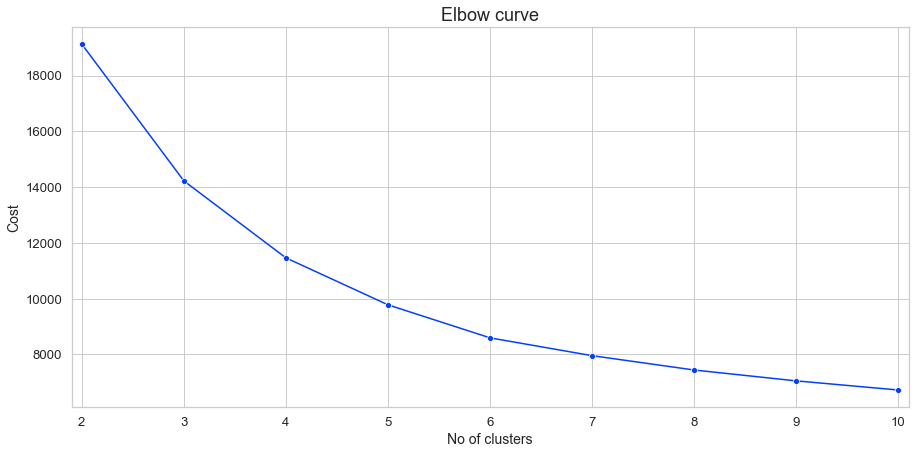

In [55]:
# Function for plotting elbow curve
def plot_elbow_curve(start, end, data):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_jobs = -1,n_clusters=k, init='Huang', random_state=42)
        test_model.fit_predict(data, categorical=[0,1])
        cost_values.append(test_model.cost_)
        
    sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
    
    plt.figure(figsize=(15, 7))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No of clusters', fontsize=14)
    ax.set_ylabel('Cost', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot();
    
# Plotting elbow curve for k between 2 and 10
plot_elbow_curve(2,10,df_prototype_std_new)

In [56]:
# fitting kprototypes with k=4
proto_new_k4 = KPrototypes(n_jobs = -1,n_clusters=4, init='Huang', random_state=42)
proto_new_k4.fit_predict(df_prototype_std_new, categorical=[0,1])
df_prototype_std_new['proto4'] = proto_new_k4.labels_

# add the cluster colum
df_prototype_std_new['proto4'] = proto_new_k4.labels_

In [57]:
df_final_summary = df_final.copy()
df_final_summary['proto4'] = proto_new_k4.labels_
df_final_summary= df_final_summary[['proto4','EducDeg','Children', 'MonthSal','ActualAge','TimeCustm']]
df_final_summary.groupby('proto4').mean()

,MonthSal,ActualAge,TimeCustm
proto4,,,
0,2255.742356,44.536840,33.573346
1,3571.315095,67.357125,35.042563
2,3298.224811,62.355925,23.627366
3,1466.260006,33.418925,23.218269


# Mergin clusters

In [58]:
df_merge = df_KH.copy()
df_merge['proto_k4'] = proto_new_k4.labels_

var_clusters = full + list(product_value_features)
var_clusters.remove('Children')
var_clusters.remove('EducDeg')

scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_merge[var_clusters])
df_merge[var_clusters] = scaled_feat

df_merge['Children'] = df_merge['Children'].astype(float)
df_merge['final_cluster'] = df_merge['Kmeans_labelsn4'].astype(str)+ ' ' + df_merge['proto_k4'].astype(str)

df_concat_final = df_merge.groupby('final_cluster')[var_clusters].mean()
df_concat_final

,MonthSal,ActualAge,TimeCustm,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,income_commit
final_cluster,,,,,,,,,,
0 0,-0.420861,-0.498801,0.730799,0.141164,-0.436659,0.059568,0.695345,0.062094,0.080659,-0.022263
0 1,1.158406,1.260762,0.985987,0.165869,-0.622440,0.208324,0.867585,0.127273,0.138819,-0.504232
0 2,1.020168,1.083539,-0.741382,0.102097,-0.580538,0.195612,0.733598,0.172245,0.198069,-0.476302
0 3,-0.987481,-1.077991,-0.602838,0.163958,-0.666799,0.122072,0.953750,0.145785,0.179528,0.447772
1 0,-0.193606,-0.272426,0.813857,-1.293791,0.975242,-0.578574,-0.772306,-0.569644,-0.563463,-0.290595
1 1,0.998902,1.000255,1.076540,-1.119150,0.629092,-0.409714,-0.440276,-0.390927,-0.398474,-0.568723
1 2,0.629624,0.599808,-0.728756,-1.268297,0.861133,-0.469921,-0.700824,-0.483436,-0.507654,-0.507036
1 3,-0.740089,-0.817444,-0.700583,-1.193975,0.730506,-0.529738,-0.417217,-0.508160,-0.509686,0.014061
2 0,-0.187249,-0.257703,0.831919,0.955931,1.022512,-0.621415,-0.792579,-0.596443,-0.604010,-0.307364


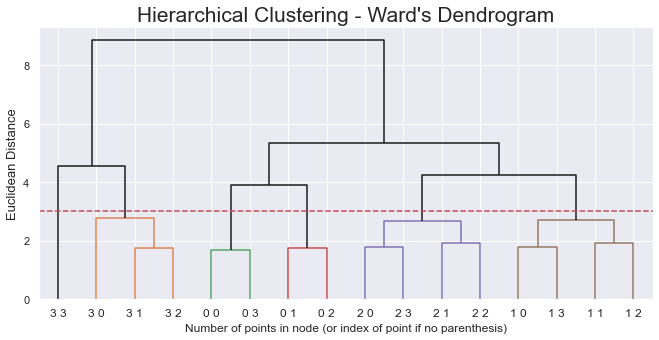

In [59]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_concat_final)  

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

# The Dendrogram parameters need to be tuned
y_threshold = 3
dendrogram(linkage_matrix, truncate_mode='level', labels=df_concat_final.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [60]:
for n_clust in range(4,7):
    hclust = AgglomerativeClustering(
        linkage='ward', 
        affinity='euclidean', 
        n_clusters=n_clust
    )
    var_name = 'hclust_labels_' + str(n_clust)
    hclust_labels = hclust.fit_predict(df_concat_final)
    df_concat_final[var_name] = hclust_labels
    df_merge = df_merge.join(df_concat_final[var_name], on = 'final_cluster')

<AxesSubplot:>

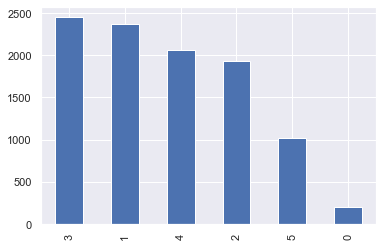

In [61]:
df_merge['hclust_labels_6'].value_counts().plot(kind='bar')

In [62]:
reducer  = umap.UMAP(n_neighbors = 320 , min_dist = 0.5)
mapper = reducer.fit_transform(df_merge[var_clusters])

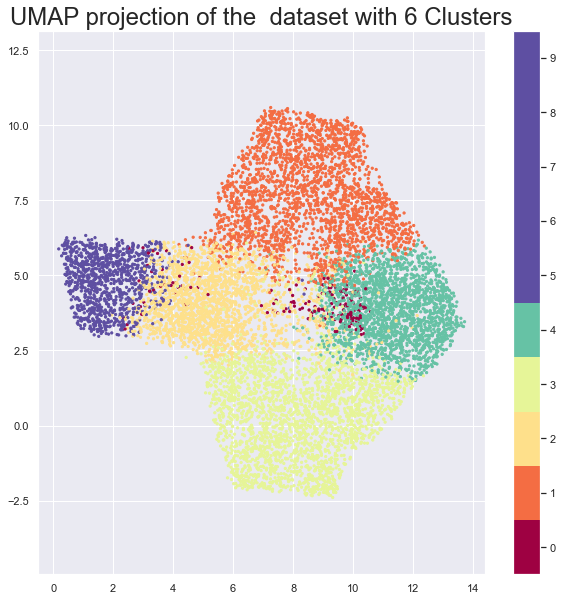

In [63]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(mapper[:, 0], mapper[:, 1], c=df_merge.hclust_labels_6, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the  dataset with 6 Clusters', fontsize=24);

# Knn for substitute class 0

In [64]:
df_merge_train = df_merge.loc[df_merge['hclust_labels_6']>=1]
df_merge_test = df_merge.loc[df_merge['hclust_labels_6']==0][var_clusters]
X = df_merge_train[var_clusters]
y = df_merge_train['hclust_labels_6']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=10,weights='distance',n_jobs=-1)
knn.fit(X_train,y_train)
print('The accuracy of the model is {0:.2f}%'.format(knn.score(X_val,y_val)))
df_merge.loc[df_merge['hclust_labels_6']==0,'hclust_labels_6']   = knn.predict(df_merge_test)

The accuracy of the model is 0.95%


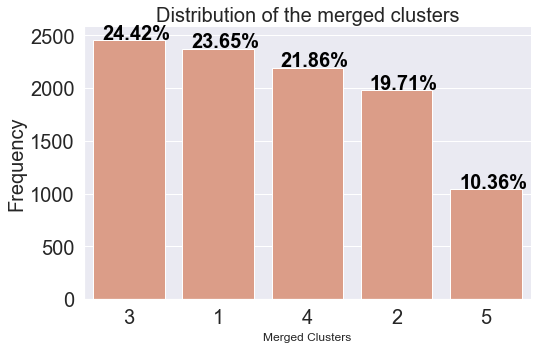

In [65]:
fig, ax = plt.subplots( figsize=(8, 5))
sns.set_style("whitegrid",{  "grid.linestyle": "dashed"})
sns.despine()
sns.countplot(x=df_merge['hclust_labels_6'], 
              color = 'darksalmon', 
              order = df_merge['hclust_labels_6'].value_counts().sort_values(ascending = False).index)

ax.tick_params(axis='both',labelsize=20)
ax.set_xlabel('Merged Clusters')
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Distribution of the merged clusters', fontsize=20)
percet = round(df_merge['hclust_labels_6'].value_counts(normalize = True)*100,2).values
freq =  df_merge['hclust_labels_6'].value_counts().values
for k,value in enumerate(percet):
    ax.text(k-0.3 ,  freq[k]+10   , str((value))+'%', color='black', fontweight='bold',fontsize=20)
sns.set_style("whitegrid",{  "grid.linestyle": "dashed"})

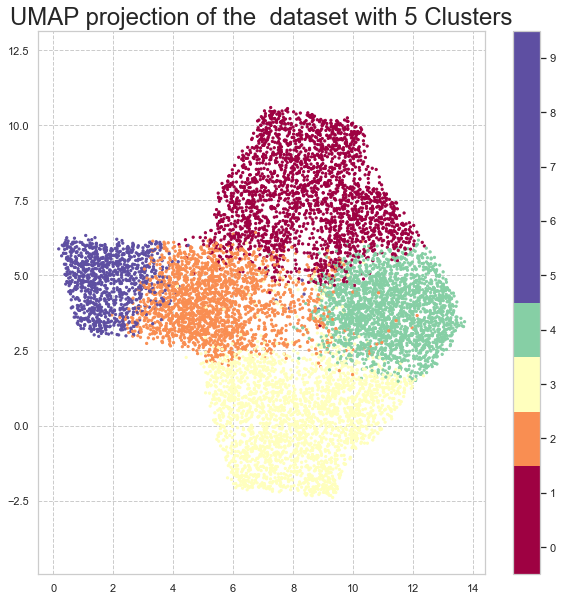

In [66]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(mapper[:, 0], mapper[:, 1], c=df_merge.hclust_labels_6, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the  dataset with 5 Clusters', fontsize=24);

# Interpretation of the Clusters

## Decision Trees

In [67]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
    inner_tree: _tree.Tree = tree.tree_
    classes = tree.classes_
    class_rules_dict = dict()

    def tree_dfs(node_id=0, current_rule=[]):
        # feature[i] holds the feature to split on, for the internal node i.
        split_feature = inner_tree.feature[node_id]
        if split_feature != _tree.TREE_UNDEFINED: # internal node
            name = feature_names[split_feature]
            threshold = inner_tree.threshold[node_id]
            # left child
            left_rule = current_rule + ["({} <= {})".format(name, threshold)]
            tree_dfs(inner_tree.children_left[node_id], left_rule)
            # right child
            right_rule = current_rule + ["({} > {})".format(name, threshold)]
            tree_dfs(inner_tree.children_right[node_id], right_rule)
        else: # leaf
            dist = inner_tree.value[node_id][0]
            dist = dist/dist.sum()
            max_idx = dist.argmax()
            if len(current_rule) == 0:
                rule_string = "ALL"
            else:
                rule_string = " and ".join(current_rule)
            # register new rule to dictionary
            selected_class = classes[max_idx]
            class_probability = dist[max_idx]
            class_rules = class_rules_dict.get(selected_class, [])
            class_rules.append((rule_string, class_probability))
            class_rules_dict[selected_class] = class_rules
    
    tree_dfs() # start from root, node_id = 0
    return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])


In [68]:
df_merge[var_clusters]=scaler.inverse_transform(df_merge[var_clusters])

cluster_report(df_merge[var_clusters],df_merge['hclust_labels_6'],min_samples_leaf=50,pruning_level=0.01)

,class_name,instance_count,rule_list
1,1,2374,[0.9665809768637532] (PremMotor > 311.6699981689453) and (ClaimsRate <= 0.6449999809265137)
3,2,1979,[0.8441955193482689] (PremMotor <= 311.6699981689453) and (ActualAge <= 53.5) and (income_commit <= 0.0659363679587841) and (PremWork <= 131.0250015258789)
0,3,2452,[0.9613370922271446] (PremMotor > 311.6699981689453) and (ClaimsRate > 0.6449999809265137)
2,4,2195,[0.9157427937915743] (PremMotor <= 311.6699981689453) and (ActualAge > 53.5)
4,5,1040,[0.8043478260869565] (PremMotor <= 311.6699981689453) and (ActualAge <= 53.5) and (income_commit <= 0.0659363679587841) and (PremWork > 131.0250015258789)[0.8707317073170732] (PremMotor <= 311.6699981689453) and (ActualAge <= 53.5) and (income_commit > 0.0659363679587841)


## Graphs for Profiling

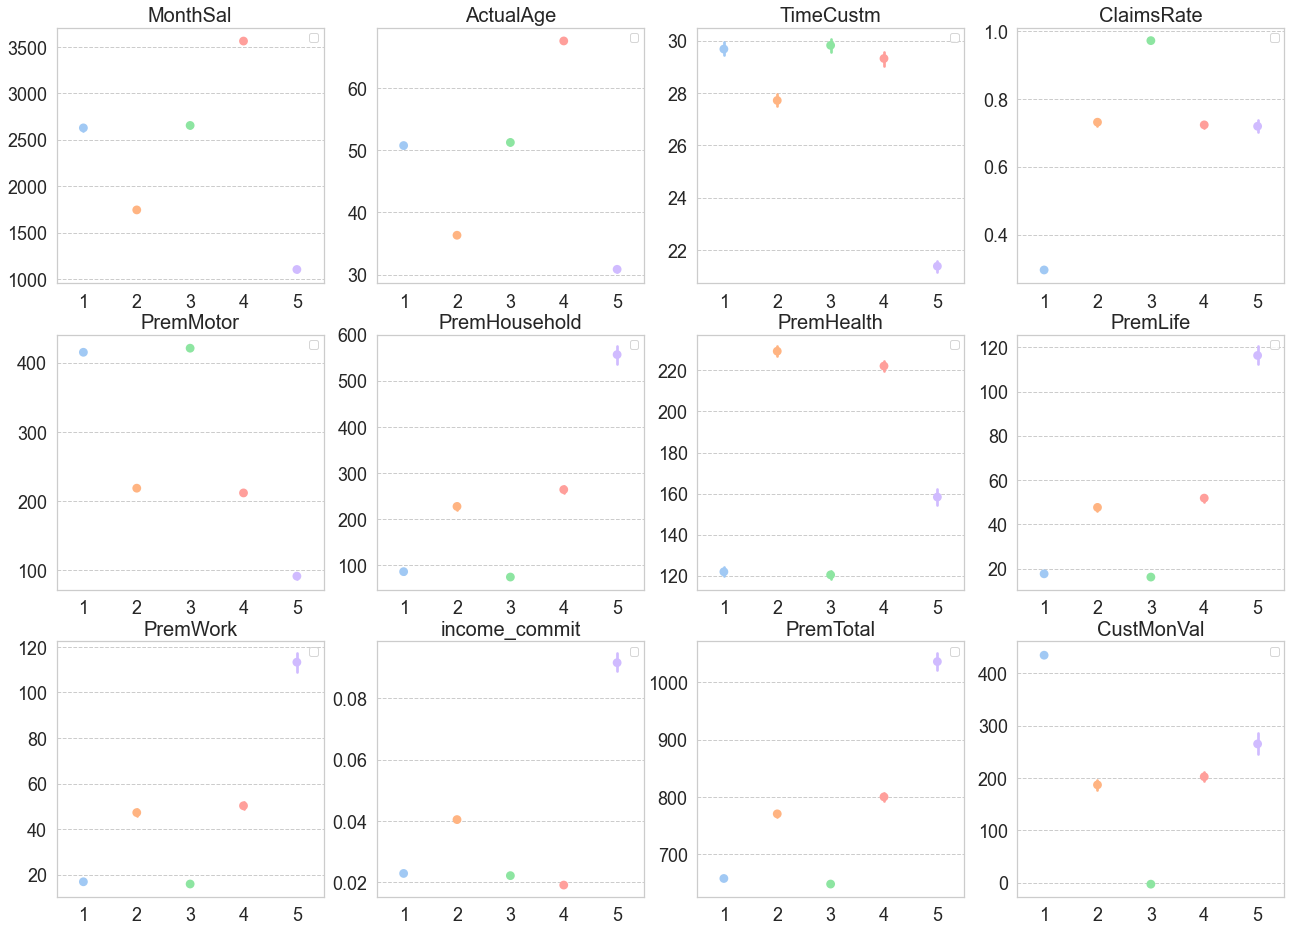

In [71]:
var_cluster_graph = var_clusters + ['PremTotal','CustMonVal']
fig, axes = plt.subplots(3,4, figsize=(22,16))

for ax, feat in zip(axes.flatten(), var_cluster_graph):
    
    sns.pointplot(y=df_merge[feat],x=df_merge['hclust_labels_6'],ax=ax,color='darksalmon',
                 palette = 'pastel')
    
    ax.set_title(feat, fontsize=20)
    ax.tick_params(axis='both',labelsize=18)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('')

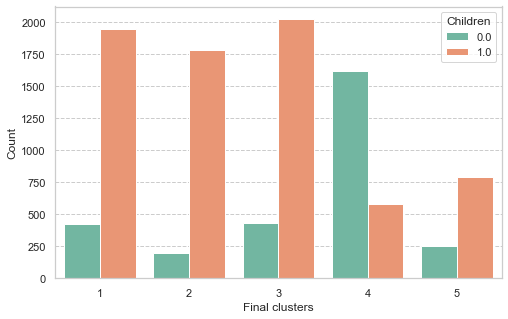

In [72]:
fig, axes = plt.subplots(figsize=(8,5))
sns.countplot(x=df_merge['hclust_labels_6'] , hue=df_merge['Children'],palette ='Set2')
sns.set_theme(style="whitegrid", palette="bright", font_scale=1.2)
plt.xlabel('Final clusters')
plt.ylabel('Count')
plt.show()

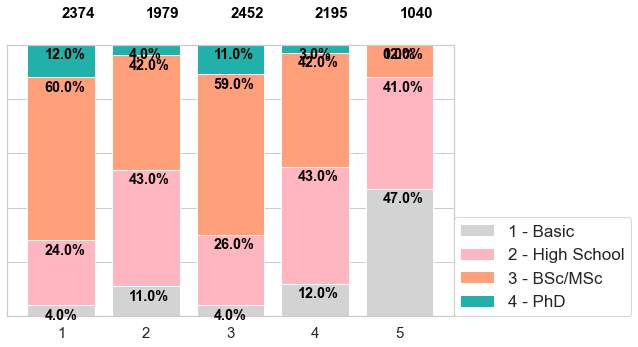

In [73]:
educ_dist= (df_merge.groupby(['EducDeg','hclust_labels_6']).size().unstack()/df_merge.groupby(['hclust_labels_6']).size())*100
educ_dist = educ_dist.round(0)
color = list(matplotlib.colors.cnames.items())[73:73+len(educ_dist)]

fig, f3_ax3 = plt.subplots(figsize=(8,5))
for j,cat in enumerate(educ_dist.columns):
    j += 1
    series_plot = educ_dist[cat]
    cumsum=0
    for i,val in enumerate(np.sort(series_plot.index.values)):
        if i ==0:
            f3_ax3.bar(cat,series_plot[i],color=color[i][0])
    
        else:
            f3_ax3.bar(cat,series_plot[i],
                       bottom = cumsum,
                       color=color[i][0])
        cumsum +=  series_plot[i]
        f3_ax3.text(j-0.2 ,  cumsum-5,
                  str(series_plot[i]) + '%', 
                 color='black', fontweight='bold')
        
    f3_ax3.text(j ,  110,
                  str(df_merge.groupby('hclust_labels_6').size()[j]), 
                 color='black', fontweight='bold',fontsize=15)
    
f3_ax3.tick_params(axis='both', which='major', labelsize=15)
f3_ax3.legend(educ_dist.index,fontsize = 17, loc=(1,0))
f3_ax3.set_yticklabels(labels='')
plt.show()

# Introduction of new observations 

In [76]:
var_tree = var_clusters + ['Children','EducDeg']
X = df_merge[var_tree]
y = df_merge['hclust_labels_6']
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)

ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(np.array(X_train['EducDeg']).reshape(-1, 1))
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=X_train.index, columns=ohc_feat_names)  
X_train_ohc = pd.concat([X_train.drop(columns='EducDeg'), ohc_df], axis=1)

ohc_feat = ohc.transform(np.array(X_val['EducDeg']).reshape(-1, 1))
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=X_val.index, columns=ohc_feat_names) 
X_val_ohc = pd.concat([X_val.drop(columns='EducDeg'), ohc_df], axis=1)

tree = DecisionTreeClassifier(min_samples_leaf=50, ccp_alpha=0.01)
tree.fit(X_train_ohc,y_train)
print('The accuracy of the model is {0:.2f}%'.format(tree.score(X_val_ohc,y_val)))

The accuracy of the model is 0.91%


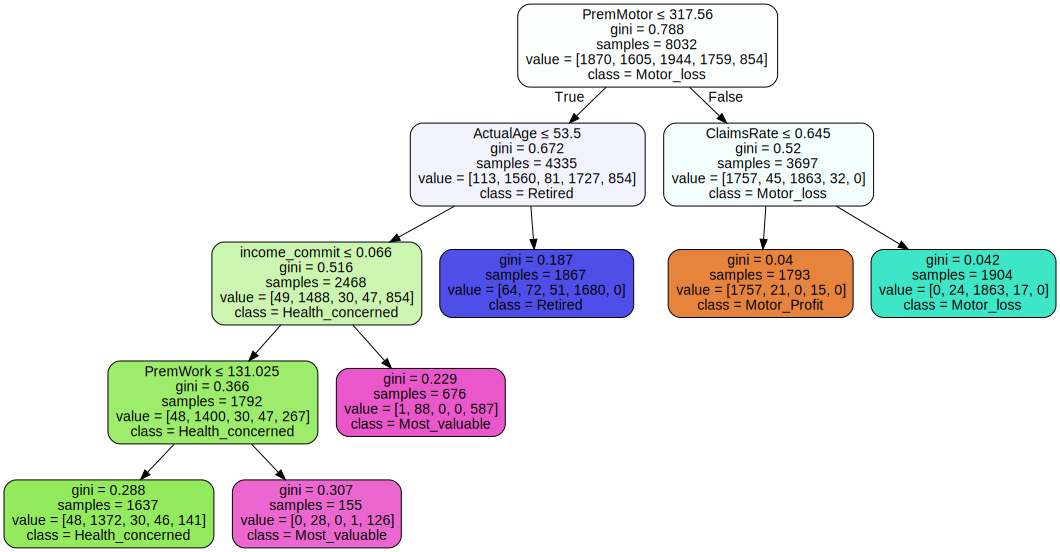

In [87]:
dot_data = export_graphviz(tree, 
                           feature_names=X_train_ohc.columns,
                           class_names = ['Motor_Profit','Health_concerned','Motor_loss','Retired','Most_valuable'],
                           filled=True,
                           rounded=True,
                           special_characters=True)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"20,20"')
graphviz.Source(pydot_graph.to_string())

In [88]:
def custom_sum(row):
    return row.sum()

df_outliers['PremTotal'] = df_outliers[['PremMotor','PremWork','PremLife','PremHealth','PremHousehold']].apply(custom_sum,axis=1)

df_outliers['income_commit'] = df_outliers['PremTotal']/(df_outliers['MonthSal']*12)

df_outliers['ActualAge'] = 2016 - df_outliers['BirthYear']

df_outliers['TimeCustm'] = 2016 - df_outliers['FirstPolYear']

df_outliers['AgeFirstPol'] = df_outliers['FirstPolYear'] - df_outliers['BirthYear']

In [89]:
df_outliers_ohc = df_outliers[var_tree]
ohc_feat = ohc.transform(np.array(df_outliers['EducDeg']).reshape(-1, 1))
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_outliers.index, columns=ohc_feat_names) 
df_outliers_ohc = pd.concat([df_outliers_ohc.drop(columns='EducDeg'), ohc_df], axis=1)
df_outliers['hclust_labels_6'] = tree.predict(df_outliers_ohc)

In [90]:
df_full = pd.concat([df_merge,df_outliers],axis=0)

In [102]:
df_full.drop(["Kmeans_labels", "centroids","Kmeans_labelsn4","proto_k4","final_cluster","hclust_labels_4","hclust_labels_5"], axis=1,inplace=True)

In [103]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10296 entries, 0 to 10134
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FirstPolYear     10296 non-null  float64
 1   BirthYear        10296 non-null  float64
 2   MonthSal         10296 non-null  float64
 3   CustMonVal       10296 non-null  float64
 4   ClaimsRate       10296 non-null  float64
 5   PremMotor        10296 non-null  float64
 6   PremHousehold    10296 non-null  float64
 7   PremHealth       10296 non-null  float64
 8   PremLife         10296 non-null  float64
 9   PremWork         10296 non-null  float64
 10  EducDeg          10296 non-null  object 
 11  GeoLivArea       10296 non-null  object 
 12  Children         10296 non-null  float64
 13  PremTotal        10296 non-null  float64
 14  income_commit    10296 non-null  float64
 15  ActualAge        10296 non-null  float64
 16  TimeCustm        10296 non-null  float64
 17  AgeFirstPol 